In [121]:
from transformers import (GPT2LMHeadModel, GPT2TokenizerFast,
                          BertForMaskedLM, BertTokenizerFast,
                          DistilBertForMaskedLM, DistilBertTokenizerFast,
                          RobertaForMaskedLM, RobertaTokenizerFast,
                          BlenderbotForCausalLM, BlenderbotTokenizer,
                          BigBirdForMaskedLM, BigBirdTokenizer,
                          ElectraForMaskedLM, ElectraTokenizerFast)
from multiprocessing import Pool
import pandas as pd
import glob
from itertools import product, combinations
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

In [122]:
from lmeval.datasets import NarrativesDataset
from lmeval.engine import StridingMLM, StridingForwardLM

In [81]:
### TO DOS:
# Compare GPT2 across window lengths and types
# Run on other transcripts
# Implement pliers extractor
# Run sample models

### Initialize list of models and parameters

In [3]:
transcripts = glob.glob('inputs/narratives/gentle/*/transcript*')
aligned = glob.glob('inputs/narratives/gentle/*/align.csv')
dataset_files = transcripts + aligned

In [4]:
model_classes = [GPT2LMHeadModel,
                 BertForMaskedLM,
                 DistilBertForMaskedLM, 
                 RobertaForMaskedLM, 
                 BlenderbotForCausalLM, 
                 BigBirdForMaskedLM,
                 ElectraForMaskedLM]
model_ids = ['gpt2', 
             'bert-base-uncased', 
             'distilbert-base-uncased',
             'roberta-base', 
             'facebook/blenderbot-400M-distill', 
             'google/bigbird-roberta-base', 
             'google/electra-base-discriminator']
tokenizer_classes = [GPT2TokenizerFast,
                     BertTokenizerFast,
                     DistilBertTokenizerFast,
                     RobertaTokenizerFast,
                     BlenderbotTokenizer,
                     BigBirdTokenizer,
                     ElectraTokenizerFast]
model_parameters = list(zip(model_classes, model_ids, tokenizer_classes))

In [5]:
ctx_lengths = [5, 10, 15, 20]

Create all combinations of files, model_parameters, and context lengths

In [6]:
parameters = list(product(dataset_files, 
                          model_parameters, 
                          ctx_lengths))
parameters = [(i[0], *i[1], i[2]) for i in parameters]

### Define validation function + utils
... also use to test validation script

In [7]:
def _make_dataset_id(datafile):
    ds_name_splits = datafile.split('/')
    narrative = ds_name_splits[3]
    ds_type = ds_name_splits[-1].split('.')[0]
    ds_id = '_'.join([narrative, ds_type])
    return ds_id

In [8]:
def _validate(datafile, model_class, model_id, tokenizer_class, ctx_length):
    tokenizer = tokenizer_class.from_pretrained(model_id)
    model = model_class.from_pretrained(model_id)
    dataset_name = _make_dataset_id(datafile)
    data = NarrativesDataset(datafile, dataset_name)
    data.text = data.text[:100]
    if any([b in model_id for b in ['bert','electra',
                                    'bigbird']]):
        engine = StridingMLM(context_length=ctx_length)
    else:
        engine = StridingForwardLM(context_length=ctx_length)
    result = engine.run(data, tokenizer, model, model_id)
    return result

In [ ]:
for p in parameters:
    _validate(*p)

In [ ]:
pool = Pool(2)

In [61]:
results = pool.starmap(_validate, parameters)
pool.close()

## Read in data and plot

In [197]:
logs_bert = glob.glob('outputs/narratives_test/*')
logs_gpt = glob.glob('outputs/narratives/*')

In [198]:
for i, l in enumerate(logs_bert):
    ldf = pd.read_csv(l, sep='\t', index_col=0)
    if i % 100 == 0:
        print(f'{i} of {len(logs_bert)}')
    if l == logs_bert[0]:
        all_logs_bert = ldf
    else:
        all_logs_bert = pd.concat([all_logs_bert, 
                              ldf], ignore_index=True)

0 of 156
100 of 156


In [199]:
c = 0
for i, l in enumerate(logs_gpt):
    if ('bert-base-uncased' not in l) and ('bigbird' not in l):
        c += 1
        ldf = pd.read_csv(l, sep='\t', index_col=0)
        if i % 100 == 0:
            print(f'{i} of {len(logs_gpt)}')
        if c == 1:
            all_logs_gpt = ldf
        else:
            all_logs_gpt = pd.concat([all_logs_gpt, 
                                  ldf], ignore_index=True)

In [200]:
all_logs = pd.concat([all_logs_bert, all_logs_gpt], ignore_index=True)

In [201]:
l25 = all_logs[all_logs['context_size']==25]
l25['is_true'] = (l25['target'] == l25['top_predicted']).astype(int)
l25['surprisal'] = -np.log2(l25['prob_true'])
l25 = l25.replace({'aligned': 'nopunct', 'transcript':'punct'})

In [202]:
metrics = ['is_true', 'surprisal', 'entropy']

In [203]:
aggs = l25.groupby(['type', 'model'])[metrics].mean().reset_index()

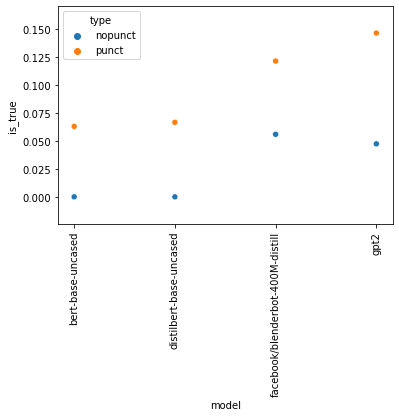

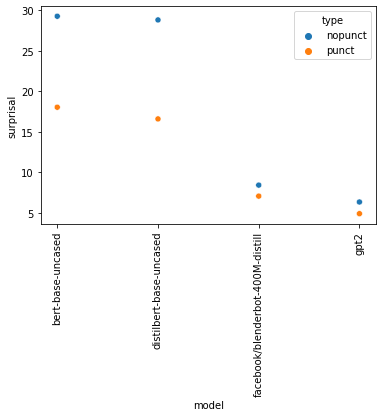

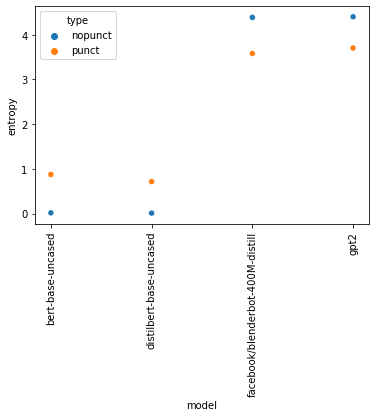

In [204]:
for m in metrics:
    sns.scatterplot(data=aggs, x='model', y=m, hue='type')
    plt.xticks(rotation=90)
    plt.show()

In [176]:
model_pairs = list(combinations(l25['model'].unique(), 2))